CIFAR10 dataset split into neg/pos and trained using normal CNN without augmentation.  
- Class weighting  

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/train/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "model": 'cnn',
    "ds_info": 'binary',
    "resample": False,
    "neg_class": ['ship'],
    "num_epochs": 100,
    "batch_size": 128,
    "img_shape": (32, 32, 3),
    "outcast": None,
    "optimizer": 'Adam',
    "final_activation": 'sigmoid',
    "learning_rate": 0.001,
    "early_stopping_patience": 10,
    "decay_rate": 0.4,              # higher number gives steeper dropoff
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

learning_rate = config["learning_rate"]
fine_tune_at = 130
fine_tune_epochs = 150
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]

neg = params["neg_count"]
pos = params["pos_count"]
total = params["ds_size"]

Negative class names:
        - ship
Positive class names:
        - cat
        - airplane
        - deer
        - automobile
        - horse
        - truck
        - dog
        - bird
        - frog

Negative samples:  5000 | 10.00%
Positive samples: 45000 | 90.00%

Total number of images: 50000
Dataset.list_files:  /mnt/sdb/cifar10/train/*/*.*g 

[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 0 0 0 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[0 1 1 1 1 1 0 1 0 1]
[1 1 1 1 1 1 1 1 0 1]
[1 1 1 1 1 1 1 1 0 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 0 1 1 1 1 1 1 1]

Full dataset sample size:        50000
Train dataset sample size:       35000
Test dataset sample size:         7500
Validation dataset sample size:   7500


# Training

### Resnet50 transfer learning
see https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/  
imbalanced-data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [4]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler

import datetime

In [5]:
metrics = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
]

In [6]:
res_net = tf.keras.applications.ResNet50(
                weights='imagenet', 
                include_top=False, 
                input_shape=config["img_shape"])

res_net.trainable = True

In [7]:
def make_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    global_average_layer = GlobalAveragePooling2D()
    output_layer = Dense(1, activation='sigmoid',
                         bias_initializer=output_bias)

    resnet50_model = tf.keras.Sequential([
            res_net,
            global_average_layer,
            output_layer])
    
    if config['optimizer'] == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif config['optimizer'] == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    resnet50_model.compile(
            optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=metrics)
    
    return resnet50_model

In [6]:
if config['verbosity'] > 0:
    cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          3

### Callbacks

In [10]:
initial_learning_rate = learning_rate
decay_steps = train_steps
batch_size = config['batch_size']
decay_rate = config['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss',verbose=1, patience=early_stopping_patience, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb, earlystopp_cb, lr_schedule_cb]

# Write config dictionary to text file
f = open(log_dir+"/config.txt","w")
f.write( str(config) )
f.close()

## Set correct initial bias


In [11]:
bias_model = make_model()

# Test run the model and show 10 first predictions of one epoch
bias_model.predict(train_ds.take(1))[:10]

array([[0.21638688],
       [0.33642092],
       [0.33706605],
       [0.32575637],
       [0.30338597],
       [0.34431285],
       [0.34886327],
       [0.27993667],
       [0.2805741 ],
       [0.3331081 ]], dtype=float32)

In [12]:
results = bias_model.evaluate(train_ds, verbose=0, steps=train_steps)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.1225


In [13]:
initial_bias = np.log([pos/neg])
print ("The initial bias should then be: {:.4f}".format(initial_bias[0]))

The initial bias should then be: 2.1972


In [14]:
new_bias_model = make_model(output_bias = initial_bias)
new_bias_model.predict(train_ds, verbose=0, steps=train_steps)

print ("Initial guess should be around:", pos/total)
new_bias_model.predict(train_ds.take(1))[:10]

Initial guess should be around: 0.9


array([[0.5613286 ],
       [0.45122844],
       [0.55198115],
       [0.48551702],
       [0.559399  ],
       [0.56884956],
       [0.5700476 ],
       [0.49504218],
       [0.52588934],
       [0.54196644]], dtype=float32)

In [15]:
results = new_bias_model.evaluate(train_ds, verbose=0, steps=train_steps)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6402


In [16]:
initial_weights = os.path.join(log_dir,'initial_weights')
new_bias_model.save_weights(initial_weights)

#### Confirm that the bias fix helps

In [17]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = 20,
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    verbose=0)

In [18]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = 20,
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    verbose=0)

In [19]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

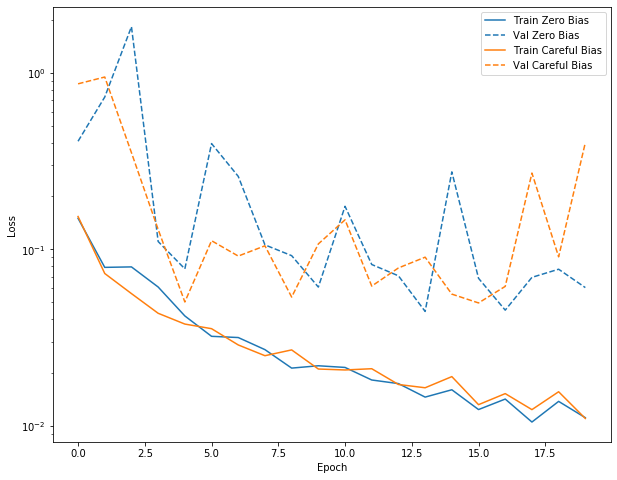

In [20]:
plt.figure(figsize=(10,8))
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

## Baseline

In [21]:
baseline_model = make_model()

baseline_history = baseline_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 273 steps, validate for 58 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
273/273 [==============================] - 24s 90ms/step - loss: 0.0231 - tp: 31352.0000 - fp: 155.0000 - tn: 3345.0000 - fn: 92.0000 - accuracy: 0.9929 - precision: 0.9951 - recall: 0.9971 - auc: 0.9973 - val_loss: 0.1339 - val_tp: 6491.0000 - val_fp: 24.0000 - val_tn: 723.0000 - val_fn: 186.0000 - val_accuracy: 0.9717 - val_precision: 0.9963 - val_recall: 0.9721 - val_auc: 0.9869

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008420727945712524.
Epoch 2/100
273/273 [==============================] - 16s 58ms/step - loss: 0.0105 - tp: 31375.0000 - fp: 65.0000 - tn: 3438.0000 - fn: 66.0000 - accuracy: 0.9963 - precision: 0.9979 - recall: 0.9979 - auc: 0.9991 - val_loss: 0.0731 - val_tp: 6661.0000 - val_fp: 80.0000 - val_tn: 661.0000 - val_fn: 22.0000 - val_accuracy: 0.9863 - val_precision: 0.9881 - val_recall: 0.9967 - val_auc: 0.9773

Epoch 0000

`Keras`
Save/load the model

In [11]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

#### Validate the results

In [22]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

Some functions

In [23]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    plt.figure(figsize=(12, 10))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [66]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    
    metrics_list = np.asarray([['tn', 'fp'], ['fn', 'tp']])
    labels = (np.asarray(["{0}\n{1:.0f}".format(metrics_list,cm) for metrics_list, cm in zip(metrics_list.flatten(), cm.flatten())])).reshape(2,2)
    
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=labels, fmt="", robust=True, annot_kws={'size':16})
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    plt.ylim(2,0)

    print('Legitimate Lesions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Lesions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Lesions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Lesions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Lesions: ', np.sum(cm[1]))
    print()

In [25]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [26]:
def numpify(dataset, model, samples=4000):
    ds_eval = dataset.unbatch().take(samples)
    labels = []
    images = []
    for img, lab in ds_eval:
        labels.append(lab.numpy())
        images.append(img.numpy())

    pred = model.predict(np.expand_dims(images, axis=0)[-1])
    
    return (labels, pred)

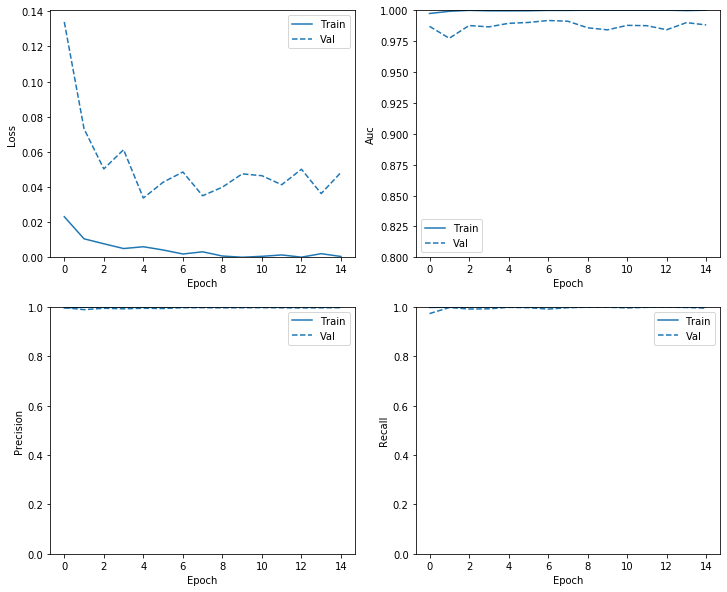

In [27]:
plot_metrics(baseline_history)

In [29]:
baseline_results = baseline_model.evaluate(val_ds, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/baseline_results.txt","w")
for name, value in zip(baseline_model.metrics_names, baseline_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

58/58 - 1s - loss: 0.0282 - tp: 6693.0000 - fp: 40.0000 - tn: 680.0000 - fn: 11.0000 - accuracy: 0.9931 - precision: 0.9941 - recall: 0.9984 - auc: 0.9905

loss : 0.028214716072774346
tp : 6693.0
fp : 40.0
tn : 680.0
fn : 11.0
accuracy : 0.9931303858757019
precision : 0.9940590858459473
recall : 0.998359203338623
auc : 0.9904524683952332

Legitimate Transactions Detected (True Negatives):  468
Legitimate Transactions Incorrectly Detected (False Positives):  3
Fraudulent Transactions Missed (False Negatives):  2
Fraudulent Transactions Detected (True Positives):  4527
Total Fraudulent Transactions:  4529



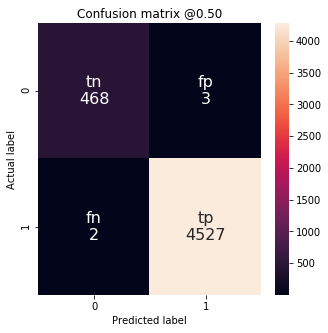

In [29]:
train_labels_baseline, train_predictions_baseline = numpify(train_ds, baseline_model, samples=5000)
val_labels_baseline, val_predictions_baseline = numpify(val_ds, baseline_model, samples=5000)

plot_cm(train_labels_baseline, train_predictions_baseline)

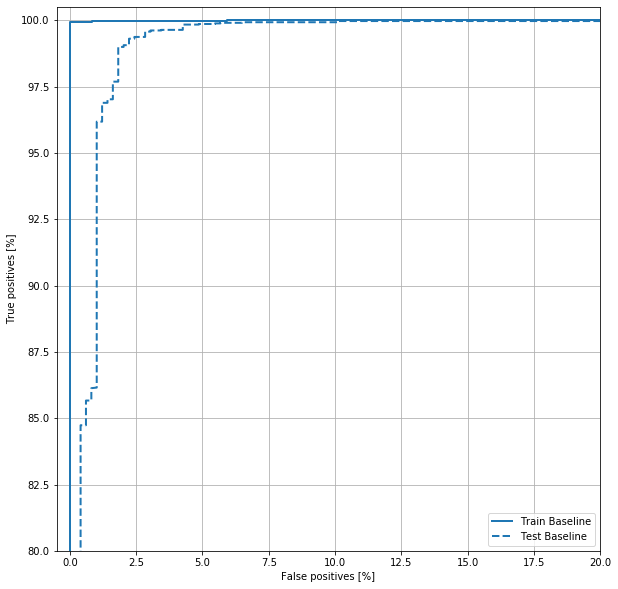

In [30]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plt.legend(loc='lower right');

### Calculate class weights
See https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

In [31]:
weight_for_0 = (1/neg)*(total)/2.0
weight_for_1 = (1/pos)*(total)/2.0

class_weight = {0: weight_for_0,
                1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 5.00
Weight for class 1: 0.56


In [32]:
weighted_model = make_model()

weighted_history = weighted_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    class_weight = class_weight,
    callbacks = callbacks
)

Train for 273 steps, validate for 58 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
273/273 [==============================] - 25s 90ms/step - loss: 0.0261 - tp: 31196.0000 - fp: 103.0000 - tn: 3397.0000 - fn: 248.0000 - accuracy: 0.9900 - precision: 0.9967 - recall: 0.9921 - auc: 0.9977 - val_loss: 0.1058 - val_tp: 6600.0000 - val_fp: 29.0000 - val_tn: 711.0000 - val_fn: 84.0000 - val_accuracy: 0.9848 - val_precision: 0.9956 - val_recall: 0.9874 - val_auc: 0.9882

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008420727945712524.
Epoch 2/100
273/273 [==============================] - 16s 58ms/step - loss: 0.0075 - tp: 31398.0000 - fp: 40.0000 - tn: 3464.0000 - fn: 42.0000 - accuracy: 0.9977 - precision: 0.9987 - recall: 0.9987 - auc: 0.9989 - val_loss: 0.0441 - val_tp: 6673.0000 - val_fp: 54.0000 - val_tn: 683.0000 - val_fn: 14.0000 - val_accuracy: 0.9908 - val_precision: 0.9920 - val_recall: 0.9979 - val_auc: 0.9844

Epoch 0000

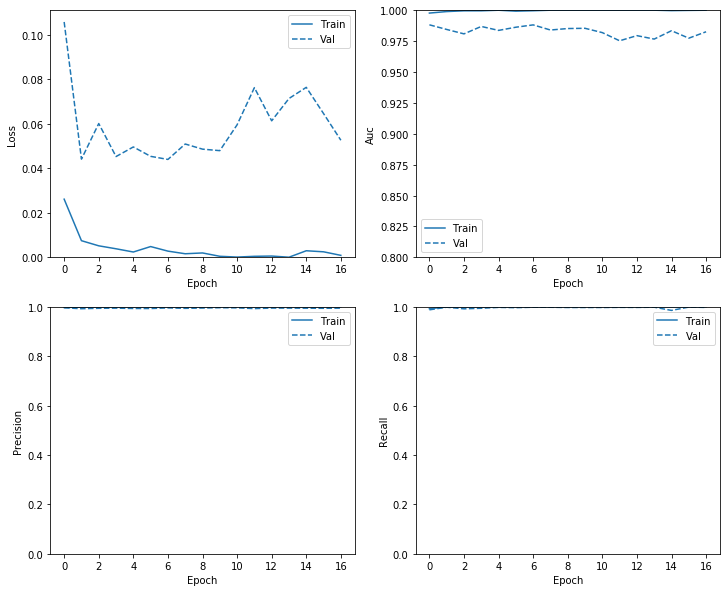

In [33]:
plot_metrics(weighted_history)

In [64]:
weighted_results = weighted_model.evaluate(val_ds, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/weighted_results.txt","w")
for name, value in zip(baseline_model.metrics_names, weighted_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

58/58 - 1s - loss: 0.0209 - tp: 6692.0000 - fp: 29.0000 - tn: 699.0000 - fn: 4.0000 - accuracy: 0.9956 - precision: 0.9957 - recall: 0.9994 - auc: 0.9999

loss : 0.0208503606424121
tp : 6692.0
fp : 29.0
tn : 699.0
fn : 4.0
accuracy : 0.9955549836158752
precision : 0.9956851601600647
recall : 0.999402642250061
auc : 0.9998872876167297



Legitimate Transactions Detected (True Negatives):  2399
Legitimate Transactions Incorrectly Detected (False Positives):  131
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  2470
Total Fraudulent Transactions:  2470



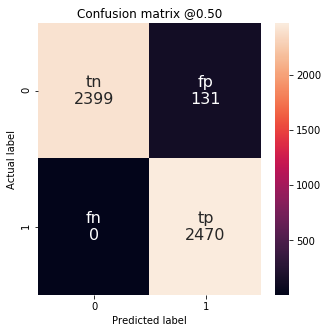

In [65]:
train_labels_weighted, train_predictions_weighted = numpify(train_ds, weighted_model, samples=5000)
val_labels_weighted, val_predictions_weighted = numpify(val_ds, weighted_model, samples=5000)

plot_cm(train_labels_weighted, train_predictions_weighted)

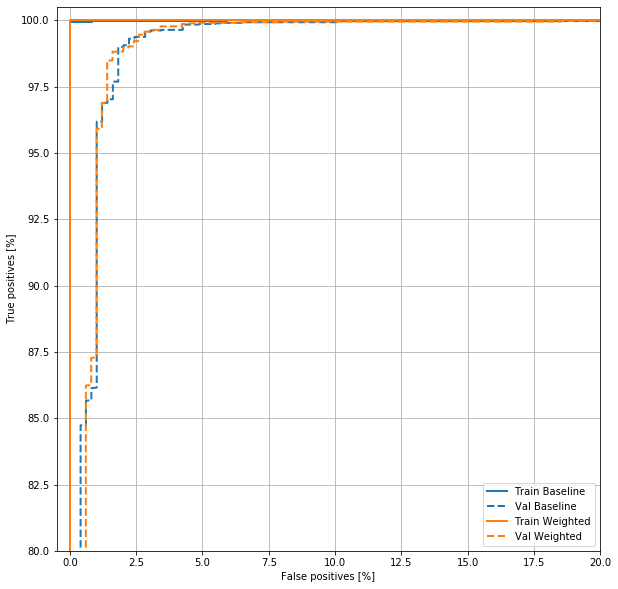

In [35]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');

## Oversampling the minority class

In [36]:
# Remove the cache
!rm -rf ./cache/*

# Set dataset resample to true to make 5050 distribution of samples
config["resample"] = True

Create training, testing and validation dataset from utils/data_prep.py

In [37]:
train_ds_resampled, test_ds_resampled, val_ds_resampled, params = create_dataset(config)

Negative class names:
        - ship
Positive class names:
        - cat
        - airplane
        - deer
        - automobile
        - horse
        - truck
        - dog
        - bird
        - frog

Negative samples:  5000 | 10.00%
Positive samples: 45000 | 90.00%

Total number of images: 50000
Dataset.list_files:  /mnt/sdb/cifar10/train/*/*.*g 

[1 1 1 1 1 1 1 1 1 1]
[1 0 0 1 0 1 1 1 1 1]
[1 1 1 1 1 1 1 0 1 1]
[1 1 1 1 0 1 1 1 1 1]
[1 1 1 1 0 1 1 1 0 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 0 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 0 1 1 1]

Resamplng the dataset..

Fractions:  [0.10214844 0.8978516 ]
Counts:  [1046. 9194.]

[0 0 0 1 0 0 1 1 1 0]
[0 1 0 0 1 0 1 1 0 1]
[0 0 0 1 1 1 0 1 1 1]
[1 0 1 1 0 0 0 1 0 1]
[1 0 0 0 0 1 0 1 1 0]
[0 0 1 0 0 1 1 1 1 0]
[0 0 0 0 0 1 0 1 1 0]
[1 1 0 1 1 1 0 1 1 0]
[0 0 1 0 0 1 1 0 0 1]
[0 0 1 1 0 1 0 0 0 0]


In [38]:
# Check the mean value is close to 0.5
for img, label in train_ds_resampled.take(3):
    print(label.numpy().mean())

0.5
0.4609375
0.5


In [39]:
resampled_steps_per_epoch = np.ceil(2.0*neg/config["batch_size"])
print (resampled_steps_per_epoch)

79.0


In [40]:
resampled_model = make_model()

resampled_history = resampled_model.fit(
    train_ds_resampled,
    steps_per_epoch = resampled_steps_per_epoch,
    epochs = config["num_epochs"],
    validation_data = test_ds_resampled,
    validation_steps = resampled_steps_per_epoch,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 79.0 steps, validate for 79.0 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
79/79 [==============================] - 34s 427ms/step - loss: 0.1257 - tp: 4823.0000 - fp: 143.0000 - tn: 4993.0000 - fn: 153.0000 - accuracy: 0.9707 - precision: 0.9712 - recall: 0.9693 - auc: 0.9921 - val_loss: 0.0759 - val_tp: 4932.0000 - val_fp: 96.0000 - val_tn: 4954.0000 - val_fn: 130.0000 - val_accuracy: 0.9777 - val_precision: 0.9809 - val_recall: 0.9743 - val_auc: 0.9963

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008420727945712524.
Epoch 2/100
79/79 [==============================] - 7s 89ms/step - loss: 0.0369 - tp: 4998.0000 - fp: 67.0000 - tn: 4989.0000 - fn: 58.0000 - accuracy: 0.9876 - precision: 0.9868 - recall: 0.9885 - auc: 0.9986 - val_loss: 0.0214 - val_tp: 5042.0000 - val_fp: 17.0000 - val_tn: 5002.0000 - val_fn: 51.0000 - val_accuracy: 0.9933 - val_precision: 0.9966 - val_recall: 0.9900 - val_auc: 0.9994

Epoch 0000

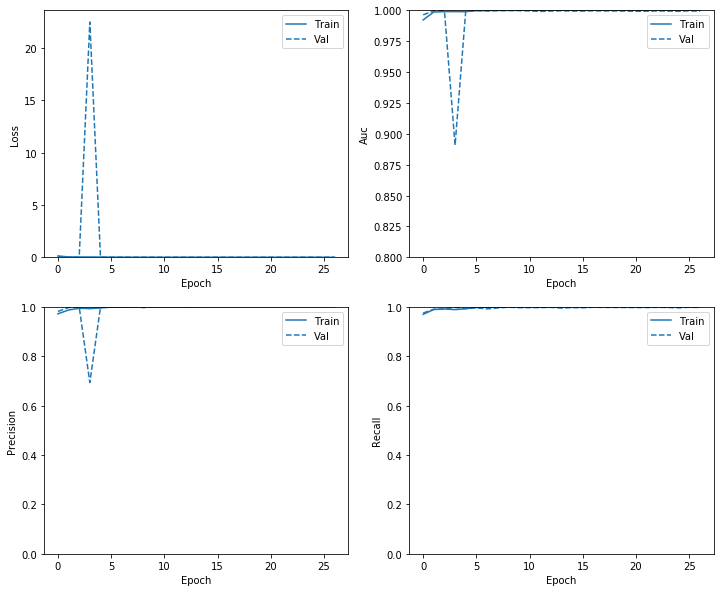

In [41]:
plot_metrics(resampled_history)

In [43]:
resampled_results = resampled_model.evaluate(val_ds_resampled, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/resampled_results.txt","w")
for name, value in zip(resampled_model.metrics_names, resampled_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

58/58 - 1s - loss: 0.0120 - tp: 6679.0000 - fp: 0.0000e+00 - tn: 731.0000 - fn: 14.0000 - accuracy: 0.9981 - precision: 1.0000 - recall: 0.9979 - auc: 0.9993

loss : 0.012027529597695508
tp : 6679.0
fp : 0.0
tn : 731.0
fn : 14.0
accuracy : 0.9981142282485962
precision : 1.0
recall : 0.9979082345962524
auc : 0.9993250370025635



In [44]:
train_labels_resampled, train_predictions_resampled = numpify(train_ds_resampled, resampled_model, samples=5000)
val_labels_resampled, val_predictions_resampled = numpify(val_ds, resampled_model, samples=5000)

Legitimate Transactions Detected (True Negatives):  2503
Legitimate Transactions Incorrectly Detected (False Positives):  1
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  2496
Total Fraudulent Transactions:  2496



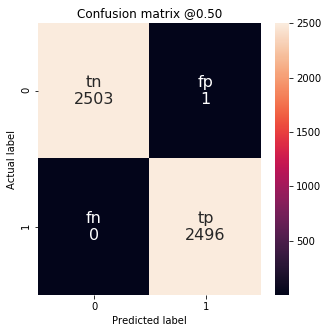

In [46]:
plot_cm(train_labels_resampled, train_predictions_resampled)

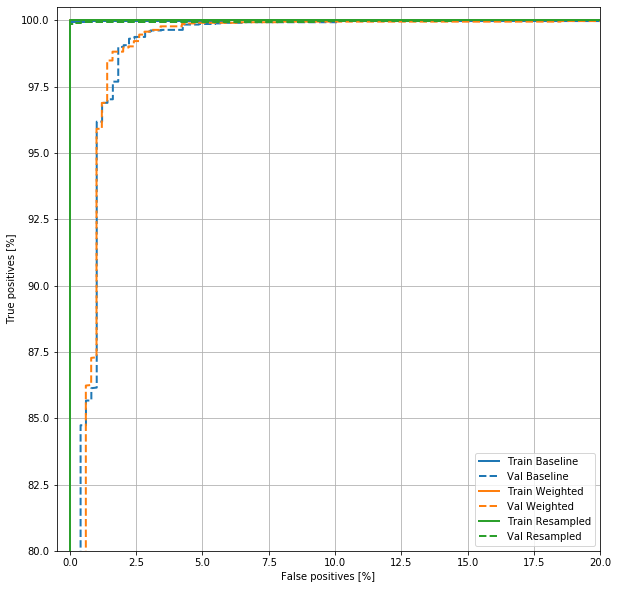

In [47]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels_resampled, train_predictions_resampled, color=colors[2])
plot_roc("Val Resampled", val_labels_resampled, val_predictions_resampled, color=colors[2], linestyle='--')

plt.legend(loc='lower right');

`Tensorboard`

## Predict new samples

In [48]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

1.0000 | 1.0
Image 59 of 128


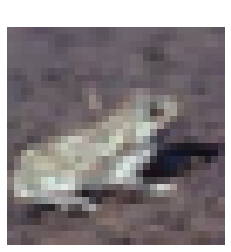

In [63]:
# Get a random image and label
rand = np.random.randint(0, config["batch_size"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = resampled_model.predict(np.expand_dims(image, axis=0))[0]
pred = predictions[0]
print("{:0.4f} | {}".format(pred, np.round(pred)))

prediction = ('Boat') if np.round(pred)==0 else ('Not boat')

print ("Image {} of {}".format(rand, config["batch_size"]))

plt.figure(frameon=False, facecolor='white');
plt.title(prediction, fontdict={'color':'white','size':20})
plt.imshow(image)
plt.axis('off');

In [50]:
# Predict one batch
predictions = resampled_model.predict(images)

print ('{:3}  {:5}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -----  ----')

for i, prediction in enumerate(predictions.flat):
    print ('\n{:3}  {:.3f}  {:.3f}'.format(i, labels[i], prediction), end='')
    if (int(labels[i]) != int(np.round(prediction))): print (" -Wrong", end='')

idx  label  pred
---  -----  ----

  0  1.000  1.000
  1  1.000  1.000
  2  1.000  1.000
  3  1.000  1.000
  4  0.000  0.000
  5  1.000  1.000
  6  1.000  1.000
  7  1.000  1.000
  8  1.000  1.000
  9  0.000  0.000
 10  1.000  1.000
 11  1.000  1.000
 12  1.000  1.000
 13  1.000  1.000
 14  1.000  1.000
 15  1.000  1.000
 16  1.000  1.000
 17  0.000  0.000
 18  0.000  0.000
 19  1.000  1.000
 20  1.000  1.000
 21  1.000  1.000
 22  0.000  0.000
 23  1.000  1.000
 24  1.000  1.000
 25  0.000  0.000
 26  1.000  1.000
 27  1.000  1.000
 28  1.000  1.000
 29  1.000  1.000
 30  1.000  1.000
 31  1.000  1.000
 32  1.000  1.000
 33  1.000  1.000
 34  1.000  1.000
 35  1.000  1.000
 36  1.000  1.000
 37  1.000  1.000
 38  1.000  1.000
 39  1.000  1.000
 40  1.000  1.000
 41  1.000  1.000
 42  1.000  1.000
 43  1.000  1.000
 44  1.000  1.000
 45  1.000  1.000
 46  0.000  0.000
 47  1.000  1.000
 48  1.000  1.000
 49  1.000  1.000
 50  1.000  1.000
 51  0.000  0.000
 52  1.000  1.000
 53  1.000 